In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from scipy.spatial.distance import braycurtis
import plotly_express as px

In [2]:
metadata_df = pd.read_csv("train_metadata.csv", index_col="sample")
data_df = pd.read_csv("train_data.csv",  index_col="sample")

## basic overview

How many samples do we have from each subject?

we have 80 baboons in the train data
76.2 samples per baboon on average


Text(0.5, 1.0, 'Number of Samples per Baboon')

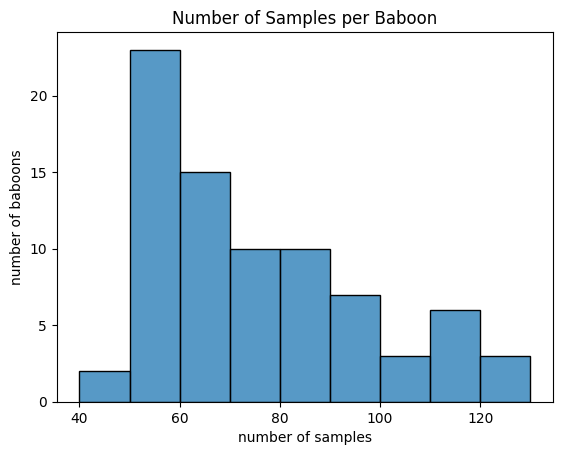

In [3]:
baboons = metadata_df.groupby("baboon_id").count()["collection_date"]
print(f"we have {len(baboons)} baboons in the train data")
print(f"{baboons.mean()} samples per baboon on average")
sns.histplot(baboons, binwidth=10, binrange=(40, 130))
plt.xlabel("number of samples")
plt.ylabel("number of baboons")
plt.title("Number of Samples per Baboon")

What is the time difference between them?

In [4]:
metadata_df["collection_date"] = (pd.to_datetime(metadata_df['collection_date']) - pd.Timestamp('1970-01-01')).dt.days
metadata_df.sort_values(by=["baboon_id", "collection_date"], inplace=True)
ls = []
ds = []
for baboon in metadata_df["baboon_id"].unique():
    curr = metadata_df[metadata_df["baboon_id"] == baboon]["collection_date"].values
    ls.append(np.nan)
    for i in range(len(curr)-1):
        ds.append(curr[i+1]-curr[i])
        ls.append(curr[i+1]-curr[i])

ds = np.array(ds)

In [5]:
sns.histplot(ds)
max_time = max(ds) 
for i in range(365//2,max_time,365//2):
    plt.vlines(x= i, ymin=0, ymax = 1000, color="black")

plt.yscale("log")
plt.xlabel("time difference between 2 subsequent samples (days)")

Text(0.5, 0, 'time difference between 2 subsequent samples (days)')

In [ ]:
indexes_list = []
visited = set()
for index, row in metadata_df.iterrows():
    if not (index in visited):
        collection_date = row['collection_date']
        baboon_id = row['baboon_id']
        matching_indexes = metadata_df[(metadata_df['collection_date'] == collection_date) & (metadata_df['baboon_id'] == baboon_id)].index.tolist()
        visited.update(matching_indexes)

    indexes_list.append(matching_indexes)
indexes_list = [index for index in indexes_list if len(index) > 1]

In [ ]:
from scipy.spatial.distance import braycurtis
import numpy as np
bray_curtis_distances = []

for indexes in indexes_list:
    for row1 in data_df.loc[indexes].iterrows():
        for row2 in data_df.loc[indexes].iterrows():
            if row1[0] != row2[0]:
                distance = braycurtis(row1[1], row2[1])
                bray_curtis_distances.append(distance)

bray_curtis_distances = np.array(bray_curtis_distances)
sns.kdeplot(bray_curtis_distances)
plt.xlabel("Bray Curtis Distance")
plt.ylabel("Density")
plt.title("Bray Curtis Distance Distribution")
plt.vlines(x = bray_curtis_distances.mean(), ymin=0, ymax=4.5, color="red", label="mean")
plt.vlines(x = np.median(bray_curtis_distances) + bray_curtis_distances.std(), ymin=0, ymax=4.5, color="green", label="median")



lower_bound = np.quantile(bray_curtis_distances, 0.025)
upper_bound = np.quantile(bray_curtis_distances, 0.975)

plt.vlines(x = lower_bound, ymin=0, ymax=4.5, color="blue", label="95% confidence interval")
plt.vlines(x = upper_bound, ymin=0, ymax=4.5, color="blue")

plt.legend()
plt.show()

## Microbiome Ordination

Calculate Bray-Curtis distances between all microbiome samples and plot PCoA

In [ ]:
d = {baboon : i for i,baboon in enumerate(metadata_df["baboon_id"].unique())}
lables = [d[baboon] for baboon in metadata_df.loc[data_df.index]["baboon_id"].values]


In [ ]:
dist_matrix = beta_diversity(braycurtis, data_df.values)
ordination = pcoa(dist_matrix)
pc_scores = ordination.samples
pc_scores

In [ ]:
px.scatter_3d(pc_scores.iloc[:,:3], x="PC1", y="PC2", z="PC3", color=lables)


In [ ]:
microbiom_with_sample_data = data_df.join(metadata_df[["baboon_id", "collection_date"]], how="inner")
microbiom_with_sample_data = microbiom_with_sample_data.sort_values(["baboon_id", "collection_date"])

In [ ]:
microbiom_with_sample_data

In [ ]:
ls = []
days =[]
label = []
for idx in range(len(microbiom_with_sample_data)-1):
    curr = microbiom_with_sample_data.iloc[[idx]].values.reshape(-1)
    next = microbiom_with_sample_data.iloc[[idx+1]].values.reshape(-1)
    if(curr[-2] == next[-2]):    
        ls.append(braycurtis(curr[:-2],next[:-2]))
        label.append(curr[-2])
        days.append(next[-1] - curr[-1])
ls = np.array(ls)

In [ ]:
print(f"calculate average distance between subsequent samples: {ls.mean()}")

In [ ]:


ls = np.array(ls)
sns.kdeplot(ls)
plt.xlabel("Bray Curtis Distance")
plt.ylabel("Density")
plt.title("Bray Curtis Distance Distribution")
plt.vlines(x = ls.mean(), ymin=0, ymax=2.5, color="red", label="mean")
plt.vlines(x = np.median(ls), ymin=0, ymax=2.5, color="green", label="median")



lower_bound = np.quantile(ls, 0.025)
upper_bound = np.quantile(ls, 0.975)

plt.vlines(x = lower_bound, ymin=0, ymax=2.5, color="blue", label="95% confidence interval")
plt.vlines(x = upper_bound, ymin=0, ymax=2.5, color="blue")

plt.legend()
plt.show()

In [ ]:
mean_baboon = microbiom_with_sample_data.groupby("baboon_id").mean()
mean_baboon.drop(columns=["collection_date"], inplace=True)

bc_scores = []
for baboon in mean_baboon.index:
    baboon_samples = metadata_df[metadata_df["baboon_id"]==baboon].index
    baboon_bc = [braycurtis(mean_baboon.loc[baboon].values,data_df.loc[sample]) for sample in baboon_samples]
    bc_scores.extend(baboon_bc)

In [ ]:
bc_scores = np.array(bc_scores)

sns.kdeplot(bc_scores)
plt.xlabel("Bray Curtis Distance")
plt.ylabel("Density")
plt.title("Bray Curtis Distance Distribution")
plt.vlines(x = bc_scores.mean(), ymin=0, ymax=4, color="red", label="mean")
plt.vlines(x = np.median(bc_scores) , ymin=0, ymax=4, color="green", label="median")



lower_bound = np.quantile(bc_scores, 0.025)
upper_bound = np.quantile(bc_scores, 0.975)

plt.vlines(x = lower_bound, ymin=0, ymax=4, color="blue", label="95% confidence interval")
plt.vlines(x = upper_bound, ymin=0, ymax=4, color="blue")

plt.legend()
plt.show()

In [ ]:
px.histogram()
import matplotlib.pyplot as plt

# Create interactive histogram
plt.hist(bray_curtis_distances, bins='auto')
plt.xlabel('Bray-Curtis Distances')
plt.ylabel('Frequency')
plt.title('Histogram of Bray-Curtis Distances')

# Add interactive functionality
plt.axvline(x=days, color='r', linestyle='--', label='Selected Value')
plt.legend()

# Show the plot
plt.show()
